In [71]:
import os, sys, glob, time
import itertools

%matplotlib inline
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.io import fits
import astropy.units as u
from astropy import table
from astropy.table import join,vstack,Table
from astropy.coordinates import SkyCoord

import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=5)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

from analyze_cluster_output import colors, shapes
from plot_periods import plot_periodcolor_histogram

In [2]:
clusters = ["IC_2391","Collinder_135","NGC_2451A","NGC_2547","IC_2602"]
dates = ["2021-06-22","2021-06-18","2021-06-21","2021-06-21","2021-07-02"]

In [3]:
class SpinModel:
    
    def __init__(self,model,model_age,period_scale,init_type="cluster"):
        """
        Inputs
        ------
        model: (string) torque law used. Options: "UpSco_Mattea2015", "UpSco_Mattea2022", UpSco_"ZeroTorque"
                                         "WideHat8Myr_Mattea2015", "WideHat8Myr_Mattea2022", "WideHat8Myr_ZeroTorque"
        model_age: (integer) model age in Myr. Must correspond to a valid age of the chosen model
        period_scale: (string) "log" or "linear"
        init_type: (string) initialization type. "tophat", "cluster", or "kde"
        """
        
        self.mass_bins = np.arange(0.05,1.4,0.1)

        self.period_scale = period_scale
        if period_scale=="log":
#             self.period_bins = np.logspace(np.log10(0.08),np.log10(40),200)
            self.period_bins = np.logspace(np.log10(0.08),np.log10(40),30)
        else:
            self.period_bins = np.linspace(0,40,30)
#             self.period_bins = np.linspace(0,40,10)

        if init_type in ["tophat","cluster","kde"]:
            self.init_type = init_type
        else:
            print("WARNING: init_type unknown, no normalization will be performed")

        # Read in the model file and calculate the histogram
        if self.init_type=="kde":
            # TODO: this needs to be replaced with the actual models once Sean sends them to me
            kde_pfile = os.path.expanduser("~/Dropbox/Models/UpSco_KDE_init/all_KDE_corrected.csv")
            kde_prob = at.read(kde_pfile)

            mod_file = os.path.expanduser(f"~/Dropbox/Models/{model}/{model}_{model_age:05d}Myr.txt")
        #     print(mod_file)
            mod = at.read(mod_file,names=["mass","prot"])
            mod["Prob"] = kde_prob["Prob"]
            
            img_raw, self.xedges, self.yedges = np.histogram2d(mod["mass"],mod["prot"],
                                                               weights=mod["Prob"],density=True,
                                                               bins=[self.mass_bins,self.period_bins])
        else:
            mod_file = os.path.expanduser(f"~/Dropbox/Models/{model}/{model}_{model_age:05d}Myr.txt")
        #     print(mod_file)
            mod = at.read(mod_file,names=["mass","prot"])
            img_raw, self.xedges, self.yedges = np.histogram2d(mod["mass"],mod["prot"],
                                                               bins=[self.mass_bins,self.period_bins])
        # Transpose the image so we can actually plot it
        # by default this is not normalized
        self.img = img_raw.T
        
        self.mass_array = mod["mass"]
        self.prot_array = mod["prot"]
        

    def normalize(self):
        # Normalize the histogram if desired
        # calculate dM and dP
        dmass = np.diff(self.mass_bins)
        dper = np.diff(self.period_bins)
        
        # Each mass bin should contain (1/nmass)*(1/dmass) of the probability
        nmass = len(dmass)
        
        if (self.init_type=="tophat") or (self.init_type=="cluster"):
            img_nomask = np.copy(self.img)

            # Multiply by dP, to sum correctly
            img_nomask_dp = img_nomask * dper[:,np.newaxis]
            # Then add up the probability in each mass bin
            sum_over_p = np.sum(img_nomask_dp, axis=0)
            # Then normalize each mass bin
            img_nomask_mnorm1 = img_nomask / sum_over_p
            img_nomask_final = img_nomask_mnorm1 / nmass / dmass

            self.img = img_nomask_final
        elif self.init_type=="kde":
            print("init_type KDE; normalization already completed")
        else:
            print("init_type unknown, no normalization performed")
        
    def add_mask(self):
        img_nomask = np.copy(self.img)
        
        # mask the image so it doesn't show cells outside the model
        model_exists = np.ones(np.shape(img_nomask),bool)
        mask = np.zeros(np.shape(img_nomask),bool)
        for i in range(len(self.mass_bins)-1):
            mass_loc = ((self.mass_array>=self.mass_bins[i]) & 
                        (self.mass_array<self.mass_bins[i+1]))
            # Calculate whether there are periods in each individual bins
            for j in range(len(self.period_bins)-1):
                per_loc = ((self.prot_array>=self.period_bins[j]) & 
                           (self.prot_array<self.period_bins[j+1]))
                in_this_bin = np.where(mass_loc & per_loc)[0]
    #             print(mass_bins[i],period_bins[j],in_this_bin)
                if len(in_this_bin)==0:
                    model_exists[j,i] = False
            # Now, for this mass range, define the mask to only exclude bins
            # beyond the range of the model
    #         print(model_exists[:,i])
            mod_min_j = min(np.where(model_exists[:,i]==True)[0])
            mod_max_j = max(np.where(model_exists[:,i]==True)[0])
            mask[:mod_min_j,i] = True
            mask[mod_max_j+1:,i] = True

        self.img = np.ma.masked_array(img_nomask,mask=mask)
        self.mask = mask
        
    def plot_hist(self,ax=None,fig=None):
        if ax is None:
            if fig is None:
                fig = plt.figure()
            ax = plt.subplot(111)
            ax.set_ylim(min(self.period_bins),max(self.period_bins))
            ax.set_xlim(1.3,0.1)
            ax.tick_params(labelsize=12)
            ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
            ax.set_ylabel("Period (d)", fontsize=16)            
            ax.patch.set_facecolor('w')
            ax.patch.set_alpha(1.0)
            fig.patch.set_facecolor('w')
            fig.patch.set_alpha(1.0)
            
        X, Y = np.meshgrid(self.xedges, self.yedges)
        if self.init_type=="kde":
            ax.pcolormesh(X, Y, self.img,cmap="viridis_r",vmin=1e-4,vmax=0.5)
        else:
            ax.pcolormesh(X, Y, self.img,cmap="viridis_r")
    #     ax.plot(mod["mass"],mod["prot"],'k.',alpha=0.25)
        ax.set_yscale(self.period_scale)
        
        return ax

    def calc_tau_sq(self, pmd):
        """ calculate tau-squared for an observed PeriodMass distribution
        """
        # area of the region containing the model
        A_pm = ((np.max(self.mass_bins)-np.min(self.mass_bins)) * 
                (np.max(self.period_bins)-np.min(self.period_bins)))
        
        # model weight? value from section 5.2.3
        fscript = 0.7

        # background term in the tau squared sum
        bkgd_i = (1-fscript)/A_pm
        
        pmd.select_obs(self)

        nprot = len(pmd.prot)
    #     print(nprot)
        sum_tau_sq = 0
        found_count = 0
        for j in range(len(self.period_bins)-1):
            in_p_bin = (pmd.prot>self.period_bins[j]) & (pmd.prot<=self.period_bins[j+1])
            for i in range(len(self.mass_bins)-1):
                if self.mask[j,i]==True:
                    # No model at this index; move on
                    continue
                else:
                    in_m_bin = (pmd.mass>self.mass_bins[i]) & (pmd.mass<=self.mass_bins[i+1])
                    observed = in_p_bin & in_m_bin
                    n_in_bin = len(np.where(observed)[0])
                    if n_in_bin>0:
                        found_count += n_in_bin
                        this_rho_f = fscript * self.img[j,i]
                        this_rho_prime = this_rho_f + bkgd_i
                        sum_tau_sq += np.log(this_rho_prime) * n_in_bin

        n_missed = nprot - found_count
        sum_tau_sq += np.log(bkgd_i) * n_missed

        self.tau_sq = -2 * sum_tau_sq

<AxesSubplot:xlabel='Mass (M$_\\odot$)', ylabel='Period (d)'>

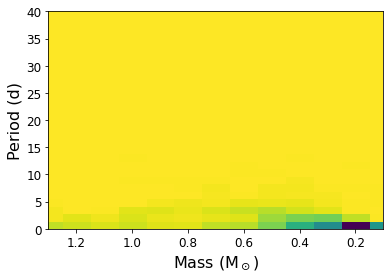

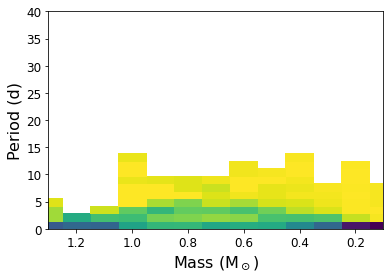

In [4]:
sm = SpinModel("UpSco_Mattea2022",30,"linear")
sm.plot_hist()
sm.normalize()
sm.add_mask()
sm.plot_hist()

init_type KDE; normalization already completed
[[0.35186291270387204 0.3056671665772376 0.2204064801313497
  0.17073319641227627 0.1544082392481076 0.1556568260022346
  0.15543607031324666 0.13958322810825138 0.16556452864119647
  0.10264396875724018 0.15286115780365558 0.2041778487330032
  0.16253181466391978]
 [0.12449757530521977 0.1494603028578293 0.1461044524324299
  0.13245012854200827 0.11891814749479589 0.101893888919216
  0.09911481677177057 0.09387307567864574 0.0830853060339854
  0.12273969187065419 0.13241949779164594 0.1371424385174816
  0.14868443492535585]
 [0.037978710950060265 0.0539449391370842 0.07466092943791565
  0.08001412967069313 0.08091182724338858 0.07447627021369835
  0.07420361631870233 0.07170282241132632 0.06768538035908708
  0.09364126720846785 0.08912563934432463 0.08404775834302843
  0.08900218073673158]
 [0.01535073107615312 0.022023149207292553 0.04005856441870847
  0.05089130451324431 0.057928309486870784 0.0566990485278758
  0.056397320675391 0.0583

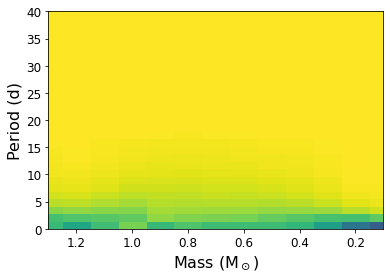

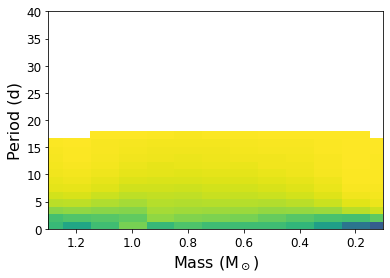

In [5]:
sm = SpinModel("WideHat8Myr_Mattea2022",10,"linear",init_type="kde")
sm.plot_hist()
sm.normalize()
sm.add_mask()
sm.plot_hist()
print(sm.img)

In [157]:
class PeriodMassDistribution:
    
    def __init__(self,max_q=0,include_blends=True,include_lit=False):
        """
        max_q: integer, maximum quality flag to include (should be 0 or 1)
        include_blends: boolean, whether or not to include potentially blended targets
        include_lit: boolean, whether or not to include literature values
        """
        # My crossmatched catalog
        per = at.read("tab_all_stars.csv")
        # per.dtype
        self.cat = Table(per, masked=True, copy=False)
        
        # Assign the catalog values to attributes
        self.prot_raw = self.cat["Prot1"]
        self.mass_raw = self.cat["Mass"]
        self.mass_err_raw = self.cat["Mass_err"]
        self.prot_mask = self.cat["Prot1"].mask
        self.mass_mask = self.cat["Mass"].mask

        # Assign masks for quality and presence of necessary values
        qmask = (self.cat["Q1"]<=max_q)
        pmask = ((self.prot_mask==False) & (self.prot_raw>0))
        pmask = pmask.filled(fill_value=False)
        mmask = (self.mass_mask==False)
        if include_blends==False:
            blmask = (self.cat["Bl?"]=="n") | (self.cat["Bl?"]=="m")
        else:
            blmask = np.ones(len(self.cat),bool)
        # If including literature values, have to replace them in the period mask
        if include_lit:
            litmask = (self.cat["LitPeriod"].mask==False) & (self.cat["LitPeriod"]>0)
            
            # I only want to use literature periods when I don't have a valid TESS period
            qmask_init = blmask & qmask & pmask
            use_lit = litmask & (qmask_init==False)
            self.prot_mask[use_lit] = False
            self.prot_raw.mask[use_lit] = False
            self.prot_raw[use_lit] = self.cat["LitPeriod"][use_lit]

            # Then the final selection should include literature or TESS periods, as appropriate
            lit_or_tess = qmask_init | litmask
            self.qmask = mmask & lit_or_tess
#             print(np.where(self.qmask)[0])
        else:
            self.qmask = pmask & mmask & qmask & blmask
        
        # I have to modify the arrays when I run tau-squared, so need to separate the raw data from down-selected
        self.prot = self.prot_raw[self.qmask]
#         # This definitely caused the mask to change, and it added masked values...
#         self.prot.mask = self.qmask
        self.mass = self.mass_raw[self.qmask]
        self.mass_err = self.mass_err_raw[self.qmask]
    
        self.figsize=(9,9)
        
        self.param_string = f"Qmax{max_q}_blends{include_blends}_lit{include_lit}"
        
    def select_obs(self, sm):
        use = ((self.mass_raw<max(sm.mass_bins)) & 
               (self.mass_raw>=min(sm.mass_bins)) & 
               self.qmask)

        self.prot = self.prot_raw[use]
        self.mass = self.mass_raw[use]
        self.mass_err = self.mass_err_raw[use]
        
    def plot_obs(self,ax=None,plot_errors=False,fig=None):
        if ax is None:
            if fig is None:
                fig = plt.figure(figsize=self.figsize)
            ax = plt.subplot(111)
            ax.set_ylim(0.07,18)
            ax.set_xlim(1.3,0.1)
            ax.tick_params(labelsize=12)
            ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
            ax.set_ylabel("Period (d)", fontsize=16)            
            ax.patch.set_facecolor('w')
            ax.patch.set_alpha(1.0)
            fig.patch.set_facecolor('w')
            fig.patch.set_alpha(1.0)

#         # This line is throwing the nan warning
#         # And it's only the errorbar line - the regular plot line doesn't throw one
#         # Weirdly, it seems to be the prot column that has masked values (it shouldn't)
#         print(type(self.mass),np.where(self.mass.mask==True)[0])
#         print(type(self.prot),np.where(self.prot.mask==True)[0])
#         print(type(self.mass_err),np.where(self.mass_err.mask==True)[0])
        ax.errorbar(self.mass,self.prot,
                    xerr=self.mass_err,
                    marker=None,linewidth=0,elinewidth=1,color="DarkGrey",alpha=0.75)

        ax.plot(self.mass,self.prot,"k.",ms=2,alpha=0.75)

        return ax
    
    def calc_mass_percentiles(self,mass_bins,percentiles=[0,10,50,75,100],ntests=1000):
        self.percentiles = percentiles
        
        mass_errs = self.mass_err_raw
        nmass = len(mass_bins)-1
        
        # Define a set of benchmarks that have both periods and masses
        nb = len(np.where(self.qmask)[0])
        
        # Randomly generate 1000 mass samples
        rng = default_rng(42)
        new_masses = rng.normal(loc=self.mass_raw[self.qmask],
                                scale=mass_errs[self.qmask],
                                size=(ntests,nb))
#         print(np.min(new_masses), np.max(new_masses))
    
        # Need to generate a set of percentiles for each mass bin
        nperc = len(self.percentiles)
        period_perc = np.zeros((nmass,nperc))
        
        for i in range(nmass):
            subset = (new_masses>=mass_bins[i]) & (new_masses<mass_bins[i+1])
            bin_perc = np.zeros((ntests,nperc))
            for j in range(ntests):
                if len(self.prot_raw[self.qmask][subset[j]])>0:
                    bin_perc[j] = np.percentile(self.prot_raw[self.qmask][subset[j]],self.percentiles)
                else:
                    bin_perc[j][:] = np.nan
            for k in range(nperc):
                period_perc[i][k] = np.nanmedian(bin_perc[:,k])
                
        self.period_perc = period_perc
        self.perc_mass_bins = mass_bins
        
    def plot_period_perc(self,ax=None,fig=None):
        if self.period_perc is None:
            print("Please compute period percentiles first!")
            return None
        
        if ax is None:
            if fig is None:
                fig = plt.figure(figsize=self.figsize)
            ax = plt.subplot(111)
            ax.set_ylim(0.07,18)
            ax.set_xlim(1.3,0.1)
            ax.tick_params(labelsize=12)
            ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
            ax.set_ylabel("Period (d)", fontsize=16)            
            ax.patch.set_facecolor('w')
            ax.patch.set_alpha(1.0)
            fig.patch.set_facecolor('w')
            fig.patch.set_alpha(1.0)
        
        nmass = len(self.perc_mass_bins)-1
        bin_widths = np.diff(self.perc_mass_bins)
        bin_centers = self.perc_mass_bins[:-1]+bin_widths/2
        
        boxes = []
        for k in range(nmass):
            boxes.append({"whislo": self.period_perc[k][0],
                  "q1": self.period_perc[k][1],
                  "med": self.period_perc[k][2],
                  "q3": self.period_perc[k][3],
                  "whishi": self.period_perc[k][4],
                  "fliers": []
                 })
            
        colorprop = {"color":mapper.to_rgba(1),"linewidth":1.5}
        ax.bxp(bxpstats=boxes,positions=bin_centers,widths=bin_widths,
               medianprops=colorprop,boxprops=colorprop,whiskerprops=colorprop,
               capprops=colorprop,manage_ticks=False,zorder=20)
        return ax

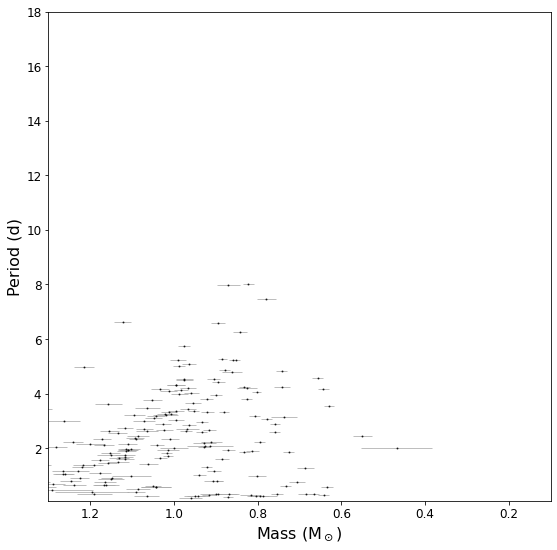

In [158]:
pmd = PeriodMassDistribution(max_q=0,include_blends=False,include_lit=False)
ax = pmd.plot_obs(plot_errors=True)

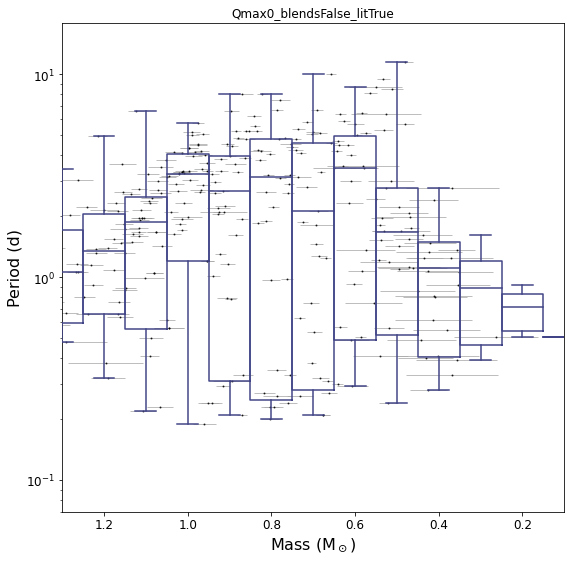

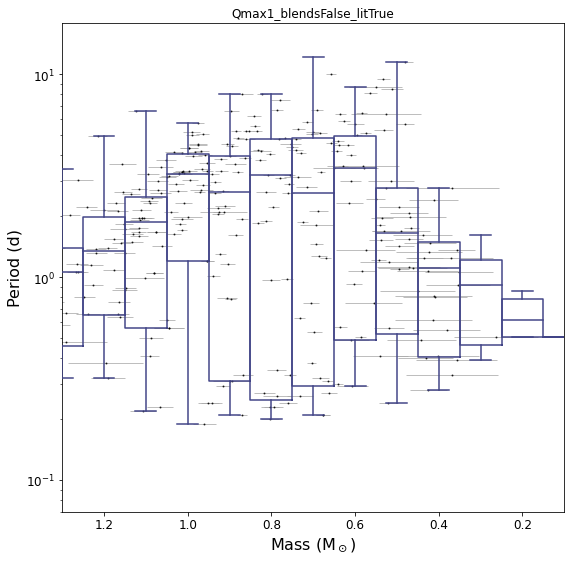

In [160]:
pmd = PeriodMassDistribution(max_q=0,include_blends=False,include_lit=True)
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14))
ax = pmd.plot_obs(plot_errors=True)
_ = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.param_string)
ax.set_yscale("log")

pmd1 = PeriodMassDistribution(max_q=1,include_blends=False,include_lit=True)
pmd1.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14))
ax1 = pmd.plot_obs(plot_errors=True)
_ = pmd1.plot_period_perc(ax1)
_ = ax1.set_title(pmd1.param_string)
ax1.set_yscale("log")

<class 'astropy.table.column.MaskedColumn'> []
<class 'astropy.table.column.MaskedColumn'> []
<class 'astropy.table.column.MaskedColumn'> []


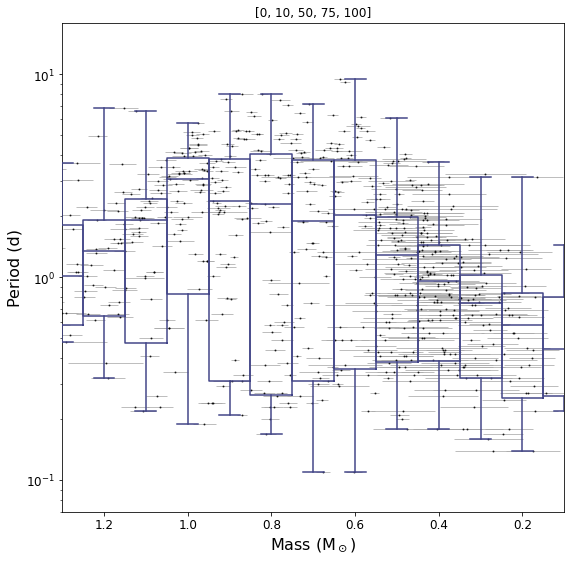

In [133]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14))
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

/Users/douglste/anaconda3/envs/lightkurve2/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


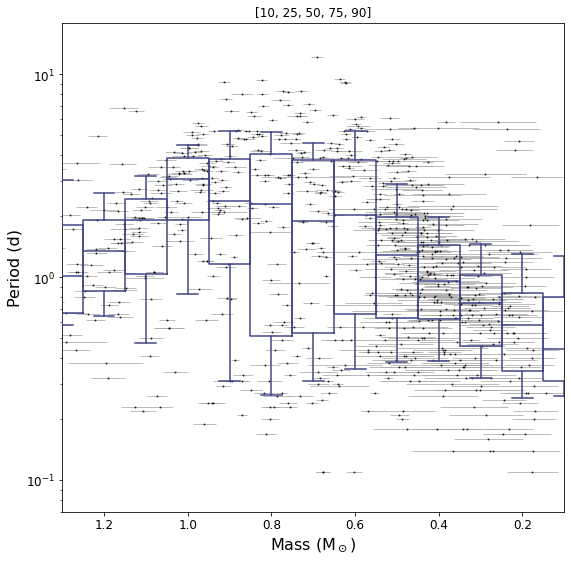

In [13]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14),percentiles=[10,25,50,75,90])
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

/Users/douglste/anaconda3/envs/lightkurve2/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


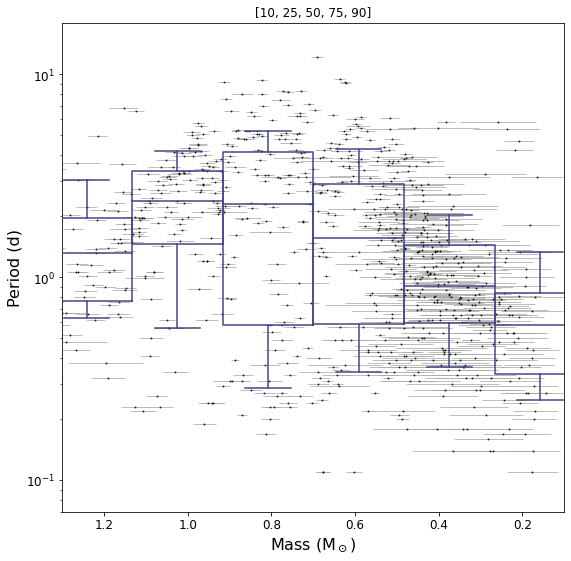

In [9]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,7),percentiles=[10,25,50,75,90])
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

/Users/douglste/anaconda3/envs/lightkurve2/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


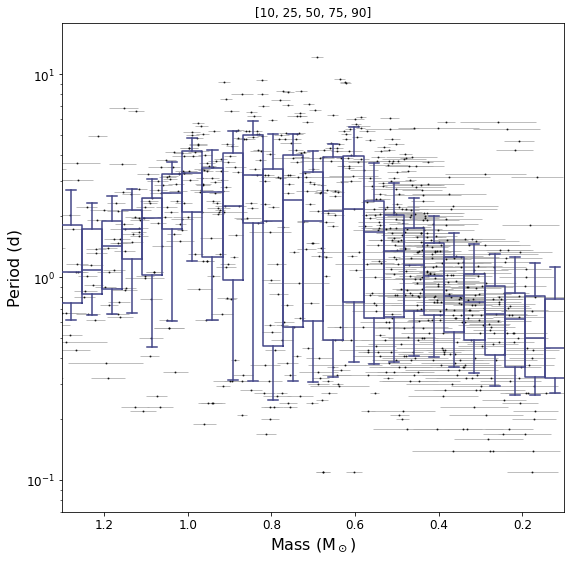

In [10]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,28),percentiles=[10,25,50,75,90])
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

UpSco_Mattea2015
UpSco_Mattea2022
UpSco_ZeroTorque


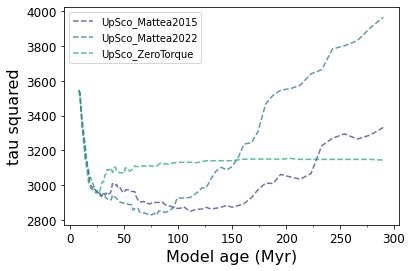

In [11]:
model_names = ["UpSco_Mattea2015","UpSco_Mattea2022","UpSco_ZeroTorque"]
period_scale = "linear"

pmd = PeriodMassDistribution()

fig = plt.figure()
fig.patch.set_facecolor('w')
fig.patch.set_alpha(1.0)
for j,model in enumerate(model_names):
    print(model)
    models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/{model}/{model}*Myr.txt"))
    # print(models)

    model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
    # print(model_ages)
    
    model_ages = model_ages[model_ages<=300]
    
    all_tau_sq = np.zeros(len(model_ages))
    for i, age in enumerate(model_ages):
        sm = SpinModel(model,age,period_scale)
        
        # Normalize the model and calculate tau-squared
        sm.normalize()
        sm.add_mask()
        sm.calc_tau_sq(pmd)

        all_tau_sq[i] = sm.tau_sq

    plt.plot(model_ages,all_tau_sq,'--',label=model,color=mapper.to_rgba(j+1),alpha=0.75)
    plt.legend(loc=2)
    plt.xlabel("Model age (Myr)",fontsize=16)
    plt.ylabel("tau squared",fontsize=16)
#     plt.title(model,fontsize=14)
    
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xticks(np.arange(0,300,25),minor=True)
plt.savefig(f"plots/tausq_ZAMS_UpSco.png",bbox_inches="tight",dpi=600)

WideHat8Myr_Mattea2015
WideHat8Myr_Mattea2022
WideHat8Myr_ZeroTorque


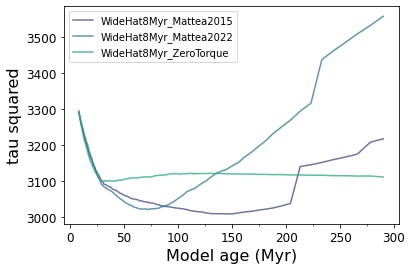

In [12]:
model_names = ["WideHat8Myr_Mattea2015","WideHat8Myr_Mattea2022","WideHat8Myr_ZeroTorque"]
period_scale = "linear"

pmd = PeriodMassDistribution()

fig = plt.figure()
fig.patch.set_facecolor('w')
fig.patch.set_alpha(1.0)
for j,model in enumerate(model_names):
    print(model)
    models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/{model}/{model}*Myr.txt"))
    # print(models)

    model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
    # print(model_ages)
    
    model_ages = model_ages[model_ages<=300]
    
    all_tau_sq = np.zeros(len(model_ages))
    for i, age in enumerate(model_ages):
        sm = SpinModel(model,age,period_scale)
        
        # Normalize the model and calculate tau-squared
        sm.normalize()
        sm.add_mask()
        sm.calc_tau_sq(pmd)

        all_tau_sq[i] = sm.tau_sq

    plt.plot(model_ages,all_tau_sq,'-',label=model,color=mapper.to_rgba(j+1),alpha=0.75)
    plt.legend(loc=2)
    plt.xlabel("Model age (Myr)",fontsize=16)
    plt.ylabel("tau squared",fontsize=16)
#     plt.title(model,fontsize=14)
    
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xticks(np.arange(0,300,25),minor=True)
plt.savefig(f"plots/tausq_ZAMS_WideHat8Myr.png",bbox_inches="tight",dpi=600)

In [177]:
display_names = {"UpSco_Mattea2015":"Matt+15; UpSco initialization",
                 "UpSco_Mattea2022":"Matt+in prep; UpSco initialization",
                 "UpSco_ZeroTorque":"Zero Torque; UpSco initialization",
                 "WideHat8Myr_Mattea2015":"Matt+15; uniform initialization",
                 "WideHat8Myr_Mattea2022":"Matt+in prep; uniform initialization",
                 "WideHat8Myr_ZeroTorque":"Zero Torque; uniform initialization"}


In [210]:
model_names = ["UpSco_Mattea2015","UpSco_Mattea2022","UpSco_ZeroTorque",
               "WideHat8Myr_Mattea2015","WideHat8Myr_Mattea2022","WideHat8Myr_ZeroTorque"]
nmod = 6
nage = 118

def run_all_models(max_q=0,include_blends=True,include_lit=False,
                   period_scale = "linear",output_filebase="tausq_ZAMS_Compare",
                   models_to_plot=model_names,zoom_ymax=None):
# plot_frames = True

    ttab = Table(np.zeros(nmod*nage).reshape(nage,nmod),names=model_names)

    pmd = PeriodMassDistribution(max_q,include_blends,include_lit)
    # TODO: make it check for the matching output csv and skip straight to plotting if found

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    fig.patch.set_alpha(1.0)
    ax = plt.subplot(111)

    fig2 = plt.figure()
    for j,model in enumerate(models_to_plot):
        
        print(model)

        if "WideHat" in model:
            init_type="kde"
        else:
            init_type="cluster"

        models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/{model}/{model}*Myr.txt"))
        # print(models)

        model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
        # print(model_ages)

        model_ages = model_ages#[model_ages<=300]

        all_tau_sq = np.zeros(len(model_ages))
        for i, age in enumerate(model_ages):
    #         print(i,age)

            sm = SpinModel(model,age,period_scale,init_type=init_type)

            # Normalize the model and calculate tau-squared
            if init_type!="kde":
                sm.normalize()
            sm.add_mask()
            sm.calc_tau_sq(pmd)

            all_tau_sq[i] = sm.tau_sq

    #         if plot_frames:
    #             if ax2 is None:
    #                 ax2 = sm.plot_hist(fig=fig2)
    #             else:
    #                 ax2 = sm.plot_hist(ax=ax2)
    #             pmd.plot_obs(ax2)
    #             fig2.savefig(f"plots/model_frames/tausq_{model}_{period_scale}_{age:05d}Myr_ZAMS.png",bbox_inches="tight",dpi=600)
    #             ax2.clear()


        if "UpSco" in model:
            ls = "--"
        else:
            ls = "-"
        ax.plot(model_ages,all_tau_sq,ls,label=display_names[model],color=mapper.to_rgba((j % 3)+1),alpha=0.75)
        ax.legend(loc=2)
        ax.set_xlabel("Model age (Myr)",fontsize=16)
        ax.set_ylabel("tau squared",fontsize=16)

        ax.tick_params(labelsize=12)
        ax.set_xticks(np.arange(0,300,25),minor=True)

        ttab[model] = all_tau_sq

        if j==0:
            ttab["Age(Myr)"] = model_ages

    outfilename = f"{output_filebase}_{pmd.param_string}"
    fig.savefig(f"plots/{outfilename}.png",bbox_inches="tight",dpi=600)

    ax.set_xlim(0,300)
    ylims = ax.get_ylim()
    if zoom_ymax is None:
        ymax = max(ttab[models_to_plot[-1]][ttab["Age(Myr)"]<350])
    else:
        ymax = zoom_ymax
    ax.set_ylim(ylims[0],ymax)
    fig.savefig(f"plots/{outfilename}_zoom.png",bbox_inches="tight",dpi=600)


    ttab.write(f"tables/{outfilename}.csv",delimiter=",",overwrite=True)

WideHat8Myr_Mattea2015
WideHat8Myr_Mattea2022
WideHat8Myr_ZeroTorque
WideHat8Myr_Mattea2015
WideHat8Myr_Mattea2022
WideHat8Myr_ZeroTorque
WideHat8Myr_Mattea2015
WideHat8Myr_Mattea2022
WideHat8Myr_ZeroTorque


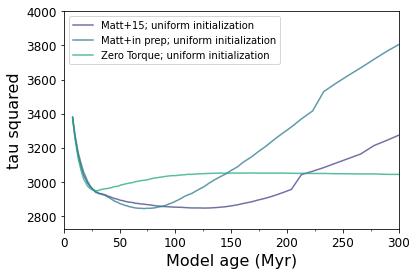

<Figure size 432x288 with 0 Axes>

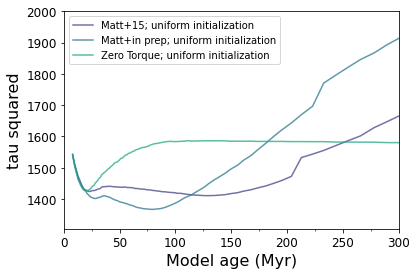

<Figure size 432x288 with 0 Axes>

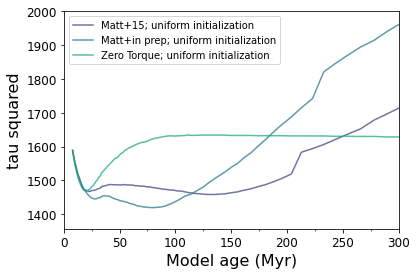

<Figure size 432x288 with 0 Axes>

In [212]:
# Original run
run_all_models(max_q=0,models_to_plot=model_names[3:],
               output_filebase="tausq_ZAMS_Compare_Widehat",zoom_ymax=4000)

# Replace blends with literature
# Only q=0
run_all_models(max_q=0,include_blends=False,include_lit=True,
               period_scale = "linear",output_filebase="tausq_ZAMS_Compare_Widehat",
               models_to_plot=model_names[3:],zoom_ymax=2000)
# allow q=1
run_all_models(max_q=1,include_blends=False,include_lit=True,
               period_scale = "linear",output_filebase="tausq_ZAMS_Compare_Widehat",
               models_to_plot=model_names[3:],zoom_ymax=2000)

In [183]:
# Find all the model ages I have
# model_year = 2022


def plot_all_models(max_q=0,include_blends=True,include_lit=False,
                    period_scale = "linear",models_to_plot=model_names):
    pmd = PeriodMassDistribution(max_q,include_blends,include_lit)

    plt.figure()
#     for j,model in enumerate(model_names):
    for j,model in enumerate(models_to_plot):
        print(model)

        if "WideHat" in model:
            init_type="kde"
        else:
            init_type="cluster"

        models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/{model}/{model}*Myr.txt"))

        model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
        # print(model_ages)

        model_ages = model_ages[(model_ages<=500) & (model_ages>=0)]

        for i, age in enumerate(model_ages):
        #     print("\n",age)
            sm = SpinModel(model,age,period_scale,init_type=init_type)
            if j==0 and i==0:
                pmd.select_obs(sm)

            # Normalize the model and calculate tau-squared
            sm.normalize()
            sm.add_mask()
            sm.calc_tau_sq(pmd)

    #         print(model,age,np.max(sm.img))
    #         print(sm.img)


            # Plot
            ax = sm.plot_hist()
            pmd.plot_obs(ax)
            plt.savefig(f"plots/model_frames/tausq_{model}_{pmd.param_string}_{period_scale}_{age:05d}Myr_ZAMS.png",bbox_inches="tight",dpi=600)
            plt.close()


In [184]:
# Original run
plot_all_models(max_q=0,models_to_plot=["WideHat8Myr_Mattea2015","WideHat8Myr_Mattea2022"])

# Replace blends with literature
# Only q=0
plot_all_models(max_q=0,include_blends=False,include_lit=True,
                period_scale = "linear",models_to_plot=["WideHat8Myr_Mattea2015","WideHat8Myr_Mattea2022"])
# allow q=1
plot_all_models(max_q=1,include_blends=False,include_lit=True,
                period_scale = "linear",models_to_plot=["WideHat8Myr_Mattea2015","WideHat8Myr_Mattea2022"])


WideHat8Myr_Mattea2015
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already 

init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE

init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE

init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already completed
WideHat8Myr_Mattea2022
init_type KDE; normalization already completed
init_type KDE; normalization already completed
init_type KDE; normalization already 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Testing Angie's KDE initialization

In [18]:
# kde_dir = os.path.expanduser("~/Dropbox/Models/UpSco_KDE_init/")
models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/UpSco_KDE_init/*.txt"))

model_tables = []
for mfile in models:
    temp_tab = at.read(mfile)
    mass = float(mfile.split("/")[-1][:3])
    temp_tab["Mass"] = np.ones(len(temp_tab))*mass
    model_tables.append(temp_tab)
mod = vstack(model_tables)

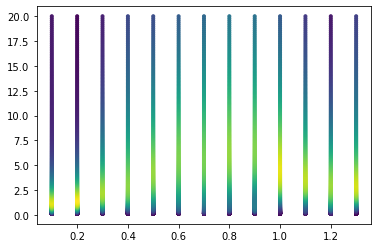

In [19]:
plt.scatter(mod["Mass"],mod["Period"],marker=".",c=mod["Prob"])

In [20]:
period_bins = np.linspace(0,40,30)
mass_bins = np.linspace(0.05,1.35,14)
dPdM = np.diff(period_bins)[0] * np.diff(mass_bins)[0]

In [21]:
hist, xedges, yedges = np.histogram2d(mod["Mass"],mod["Period"],weights=mod["Prob"],density=True,
                                     bins=[mass_bins,period_bins])
img = hist.T

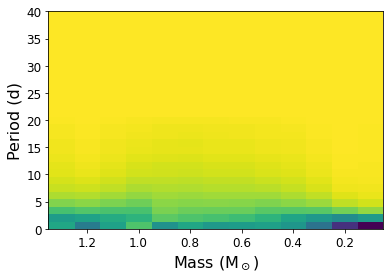

In [22]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_xlim(1.35,0.05)
ax.tick_params(labelsize=12)
ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
ax.set_ylabel("Period (d)", fontsize=16)            
ax.patch.set_facecolor('w')
ax.patch.set_alpha(1.0)
fig.patch.set_facecolor('w')
fig.patch.set_alpha(1.0)
            
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, img,cmap="viridis_r")


In [23]:
np.sum(img)

7.249999999999999

In [24]:
np.sum(img[:,0]*np.diff(period_bins))

0.7692307692307693

In [25]:
1/13

0.07692307692307693

In [26]:
np.sum(img*dPdM)

1.0

In [28]:
np.max(img)

0.3083432346658118

# Demo PMD/model plots for the CS poster

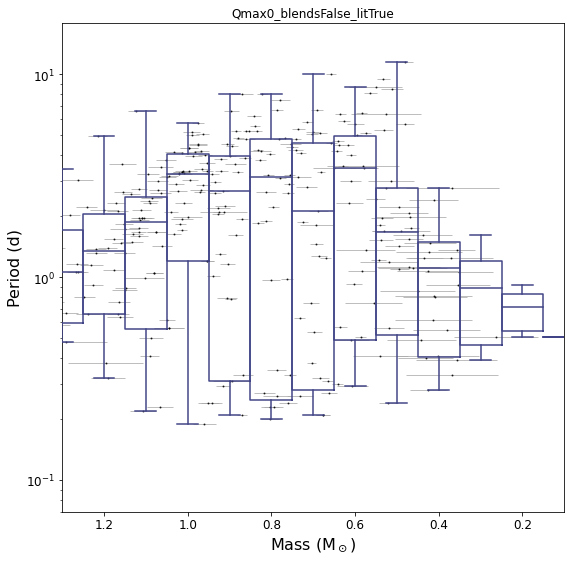

In [185]:
pmd = PeriodMassDistribution(max_q=0,include_blends=False,include_lit=True)
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14))
ax = pmd.plot_obs(plot_errors=True)
_ = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.param_string)
ax.set_yscale("log")

likelihood 4.925922629861668e-307


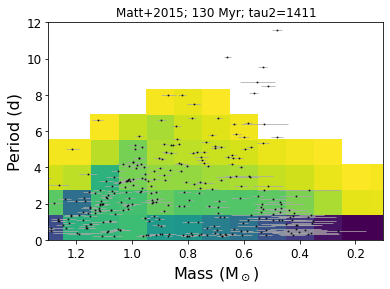

In [216]:
sm = SpinModel("WideHat8Myr_Mattea2015",130,"linear",
               init_type="kde")
pmd.select_obs(sm)

# Normalize the model and calculate tau-squared
# sm.normalize()
sm.add_mask()
sm.calc_tau_sq(pmd)

# Plot
ax = sm.plot_hist()
pmd.plot_obs(ax)
ax.set_ylim(0,12)

ax.set_title(f"Matt+2015; 130 Myr; tau2={sm.tau_sq:.0f}")
plt.savefig(f"plots/tausq_WideHat8Myr_Mattea2015_{pmd.param_string}_linear_00130Myr_ZAMS.png",bbox_inches="tight",dpi=600)

like = np.exp(-0.5*sm.tau_sq)
print(f"likelihood {like}")

likelihood 1.541387730575528e-297


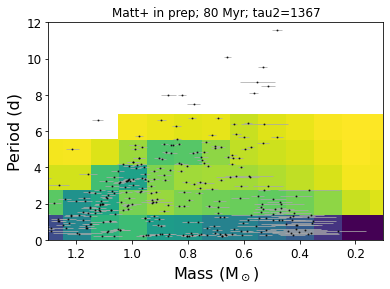

In [217]:
sm = SpinModel("WideHat8Myr_Mattea2022",80,"linear",
               init_type="kde")
pmd.select_obs(sm)

# Normalize the model and calculate tau-squared
# sm.normalize()
sm.add_mask()
sm.calc_tau_sq(pmd)

# Plot
ax = sm.plot_hist()
pmd.plot_obs(ax)
ax.set_ylim(0,12)
ax.set_title(f"Matt+ in prep; 80 Myr; tau2={sm.tau_sq:.0f}")
plt.savefig(f"plots/tausq_WideHat8Myr_Mattea2022_{pmd.param_string}_linear_00080Myr_ZAMS.png",bbox_inches="tight",dpi=600)

like = np.exp(-0.5*sm.tau_sq)
print(f"likelihood {like}")